In [1]:
import utils as u
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib as mpl


%matplotlib widget

with open('modal_m1.pkl', 'rb') as f:
    modal_analysis_m1 = pickle.load(f)
modal_analysis_m1

{'table': 'Medium_1',
 'freq': array([ 75, 149, 160, 184, 268, 286, 319, 345, 427, 460, 515, 602, 654]),
 'xi': array([-0.00026   , -0.00017893, -0.000337  , -0.000808  , -0.000549  ,
        -0.000603  , -0.000752  , -0.000908  , -0.000219  , -0.000758  ,
        -0.001235  , -0.001077  , -0.000958  ]),
 'ratios': array([1.        , 1.98666667, 2.13333333, 2.45333333, 3.57333333,
        3.81333333, 4.25333333, 4.6       , 5.69333333, 6.13333333,
        6.86666667, 8.02666667, 8.72      ]),
 'xi_mod': array([-0.08874667, -0.03074233, -0.05392   , -0.11241739, -0.05244179,
        -0.05397483, -0.06034859, -0.06737623, -0.01312974, -0.04218435,
        -0.06139029, -0.04579934, -0.03749969])}

In [2]:
def calcul_e_nu(omega,Lx,Ly,rapport):
    return(rapport * omega**2 / (((np.pi/Lx)**2 + (np.pi/Ly)**2)**2)   )

def omega_pq (p,q,h,E_nu,rho,Lx,Ly) :    #Calcul analytique des pulsations propres d'une plaque en appuis simple
    return np.sqrt(E_nu*h**2/(12*rho)) * ((p*np.pi/Lx)**2+(q*np.pi/Ly)**2)

def phi_pq (p,q,x,y, Lx, Ly) :  #Calcul analytique des déformées des modes d'une plaque en appuis simple
    """
    ## Inputs
    - p : numéro du mode selon x
    - q : numéro du mode selon y
    - x : arrayLike, vecteur des abscisses
    - y : arrayLike, vecteur des ordonnées

    ## Outputs
    - phi_pq : arrayLike, size (Nx,Ny), déformée du mode (p,q) en tous les points (x,y) du maillage
    """
    return np.sin(p*np.pi*x[:,np.newaxis]/Lx)*np.sin(q*np.pi*y[np.newaxis,:]/Ly)

def f_plaque(Lx,Ly,h,E_nu,rhoT):
    NB, MB = 3, 3 #Nombre de modes selon x, y
    NmB = NB * MB   #Nombre de modes total considéré dans le modèle de plaque

    dx, dy = 10e-3, 10e-3
    x, y = np.arange(0,Lx,dx), np.arange(0,Ly,dy)
    Nx, Ny = len(x), len(y)
    X_plate, Y_plate = np.meshgrid(x, y)
    X_ravel, Y_ravel = np.ravel(X_plate), np.ravel(Y_plate)

    ## Calcul des modes

    wnB = np.zeros(NmB)
    NmB_idx = np.zeros((2,NmB))   #Cette liste permet de remonter du mode contracté "i" au mode réel (n_i,m_i) en appelant NmB_idx[:,i]
    j = 0
    for n in range(1,NB+1) :
        for m in range(1,MB+1) :
            wnB[j] = omega_pq(n,m, h, E_nu,rhoT,Lx,Ly)
            NmB_idx[0,j] = n
            NmB_idx[1,j] = m
            j += 1

    ### Tri par ordre de fréquences croissantes
    tri_idx = np.argsort(wnB)

    wnB = wnB[tri_idx]    #On range les pulsations par ordre croissant 

    return(wnB/2/np.pi)
def mode_plaque(Lx,Ly,h,E_nu,rhoT):
    NB, MB = 3, 3 #Nombre de modes selon x, y
    NmB = NB * MB   #Nombre de modes total considéré dans le modèle de plaque

    dx, dy = 10e-3, 10e-3
    x, y = np.arange(0,Lx,dx), np.arange(0,Ly,dy)
    Nx, Ny = len(x), len(y)
    X_plate, Y_plate = np.meshgrid(x, y)
    X_ravel, Y_ravel = np.ravel(X_plate), np.ravel(Y_plate)

    ## Calcul des modes

    wnB = np.zeros(NmB)
    NmB_idx = np.zeros((2,NmB))   #Cette liste permet de remonter du mode contracté "i" au mode réel (n_i,m_i) en appelant NmB_idx[:,i]
    j = 0
    for n in range(1,NB+1) :
        for m in range(1,MB+1) :
            wnB[j] = omega_pq(n,m, h, E_nu,rhoT,Lx,Ly)
            NmB_idx[0,j] = n
            NmB_idx[1,j] = m
            j += 1

    ### Tri par ordre de fréquences croissantes
    tri_idx = np.argsort(wnB)

    wnB = wnB[tri_idx]    #On range les pulsations par ordre croissant 
    NmB_idx = NmB_idx[:,tri_idx]      #On ordonne les modes par ordre croissant

    ### Déformées

    phiB_NxNy_NmB = np.zeros((Nx*Ny,NmB)) #Matrice des déformées avec les 2 dimensions spatiales applaties en 1 dimension
    for mode in range (NmB) :
        n, m = NmB_idx[0,mode], NmB_idx[1,mode]
        phiB_NxNy_NmB[:,mode] = phi_pq(n, m , x, y, Lx, Ly).ravel()

    return(wnB/2/np.pi,phiB_NxNy_NmB,x,y)

##phiB_NxNy_NmB[:,j],(Nx,Ny)

In [3]:
Lx = 0.40
Ly = 0.26

fond_m1 = 75
h_m1 = 2.95e-3 
masse_m1 = 236e-3
rho_m1 = masse_m1 / (Lx * Ly * h_m1)
Rapport_m1 = 12 * rho_m1 / h_m1**2
E_nu_m1 = calcul_e_nu(fond_m1*np.pi*2,Lx,Ly,Rapport_m1)

In [4]:
E_nu_m1

5460915748.547312

In [5]:
E_nu_m1 / 3206458380

1.7030989027050187

In [6]:
f_base,phiB_NxNy_NmB,x,y = mode_plaque(Lx,Ly,h_m1,E_nu_m1,rho_m1)
Nx = len(x)
Ny = len(y)

In [7]:
X_che1 = 13 
Y_che1 = 8

X_che2 = 19
Y_che2 = 11

In [8]:
from data_loader import *

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/io/matlab/_mio.py:226: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


{'0': 'Metal', '1': 'Medium_1', '2': 'Plexi', '3': 'Medium_2'}


In [9]:
idx_mat = 1 #Je choisis le matériau d'indice 1

dico_pos1 = deforme_Nta_Npos[idx_mat,0]
dico_pos2 = deforme_Nta_Npos[idx_mat,1]

freq1 = dico_pos1['freq']
FRF1 = dico_pos1['FRF']

freq2 = dico_pos2['freq']
FRF2 = dico_pos2['FRF']

f_fond = modal_analysis_m1['freq']

In [10]:
phiB_NxNy_NmB_zeros = np.zeros_like(phiB_NxNy_NmB)

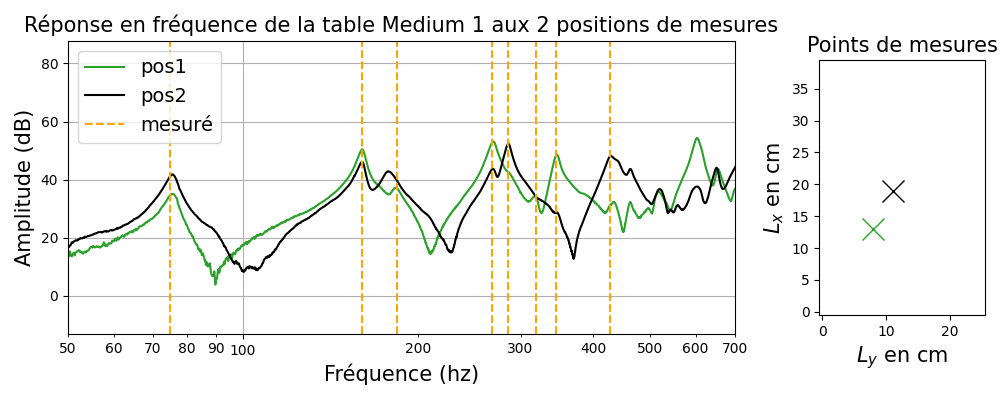

In [11]:
plt.figure(figsize=(10,4))
a1 = plt.subplot2grid((1,4),(0,0),colspan = 3)
a2 = plt.subplot2grid((1,4),(0,3),colspan=1)
a1.semilogx(freq1,20*np.log10(np.abs(FRF1)),'tab:green',label='pos1')
a1.semilogx(freq2,20*np.log10(np.abs(FRF2)),'k',label='pos2')
a1.set_xlim(50,700)
a1.set_xlabel("Fréquence (hz)",size=15)
a1.set_ylabel("Amplitude (dB)",size=15)
import matplotlib.ticker as mticker
a1.xaxis.set_minor_formatter(mticker.ScalarFormatter())
a1.xaxis.set_major_formatter(mticker.ScalarFormatter())
a1.grid()

a1.axvline(f_fond[0],ls='--',color='orange',label='mesuré')
for i in range(2,min(len(f_fond),len(f_base))):
    a1.axvline(f_fond[i],ls='--',color='orange')
a1.legend(fontsize=14)

a2.imshow(np.reshape(1 + phiB_NxNy_NmB_zeros[:,0],(Nx,Ny)),cmap="binary",origin='lower')
a2.plot(Y_che1,X_che1,color='tab:green',marker='x',label='pos1',markersize='16')
a2.plot(Y_che2,X_che2,'kx',label='pos2',markersize='16')
a2.set_xlabel('$L_y$ en cm',size=15)
a2.set_ylabel('$L_x$ en cm',size=15)
a1.set_title("Réponse en fréquence de la table Medium 1 aux 2 positions de mesures",size=15)
a2.set_title("Points de mesures",size=15)
plt.tight_layout()
plt.savefig("Rep_en_Freq_Med1.png",dpi=400,transparent = True)
plt.show()

In [12]:
pip install latex


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


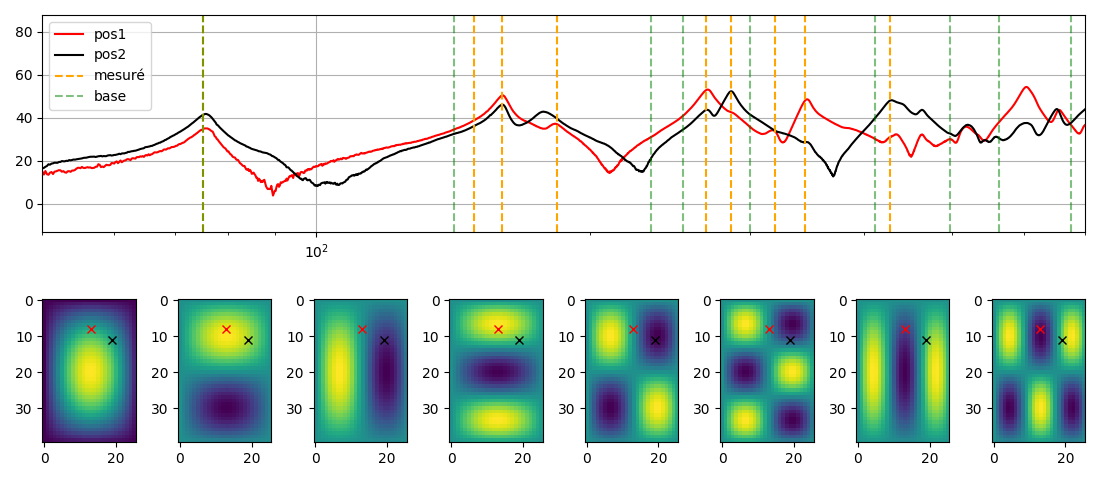

In [13]:
N_mode= 8
plt.figure(figsize=(11,5))
a1 = plt.subplot2grid((2,N_mode),(0,0),colspan = N_mode)
a1.semilogx(freq1,20*np.log10(np.abs(FRF1)),'r',label='pos1')
a1.semilogx(freq2,20*np.log10(np.abs(FRF2)),'k',label='pos2')
#a1.set_title(dico_pos1["mat_table"])
a1.axvline(f_fond[0],ls='--',color='orange',label='mesuré')
a1.axvline(f_base[0],ls='--',color='green',label="base",alpha=0.5)
for i in range(1,min(len(f_fond),len(f_base))):
    a1.axvline(f_fond[i],ls='--',color='orange')
    a1.axvline(f_base[i],ls='--',color='green',alpha=0.5)

a1.grid()
a1.legend()
a1.set_xlim(50,700)
for i in range(N_mode):
    ax = plt.subplot2grid((2,N_mode),(1,i),rowspan = 1, colspan = 1)
    ax.imshow(np.reshape(phiB_NxNy_NmB[:,i],(Nx,Ny)))
    ax.plot(X_che1,Y_che1,'rx',label='pos1')
    ax.plot(X_che2,Y_che2,'kx',label='pos2')
    #ax.set_title(f'f: {f_base[i]:0.1f} Hz')
plt.tight_layout()
plt.show()

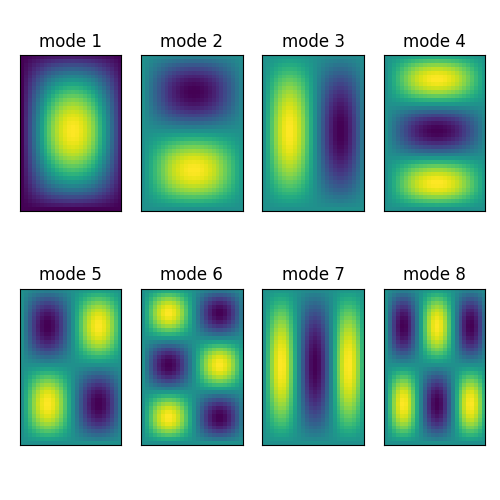

In [14]:
plt.figure(figsize=(5,5))
for i in range(4):
    ax = plt.subplot2grid((2,4),(0,i),rowspan = 1, colspan = 1)
    #if i == 0:
    #    ax.set_ylabel('L_x en cm',size=15)
    #ax.set_xlabel('L_y en cm',size=15)

    ax.imshow(np.reshape(phiB_NxNy_NmB[:,i],(Nx,Ny)),origin="lower",cmap="viridis")
    #ax.plot(Y_che1,X_che1,'rx',label='pos1',markersize=15)
    #ax.plot(Y_che2,X_che2,'bx',label='pos2',markersize=15)
    #ax.set_title(f'f: {f_base[i]:0.1f} Hz')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'mode {i+1}')
for i in range(4):
    ax = plt.subplot2grid((2,4),(1,i),rowspan = 1, colspan = 1)
    #if i == 0:
    #    ax.set_ylabel('L_x en cm',size=15)
    #ax.set_xlabel('L_y en cm',size=15)

    ax.imshow(np.reshape(phiB_NxNy_NmB[:,4+i],(Nx,Ny)),origin="lower",cmap="viridis")
    #ax.plot(Y_che1,X_che1,'rx',label='pos1',markersize=15)
    #ax.plot(Y_che2,X_che2,'bx',label='pos2',markersize=15)
    #ax.set_title(f'f: {f_base[i]:0.1f} Hz')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'mode {4+i+1}')
plt.tight_layout()
plt.show()

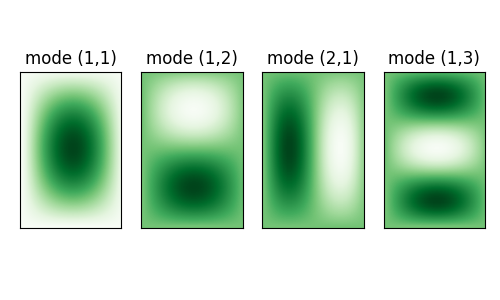

In [15]:
title = ['mode (1,1)','mode (1,2)','mode (2,1)', 'mode (1,3)']

plt.figure(figsize=(5,3))
for i in range(4):
    ax = plt.subplot2grid((1,4),(0,i),rowspan = 1, colspan = 1)
    #if i == 0:
    #    ax.set_ylabel('L_x en cm',size=15)
    #ax.set_xlabel('L_y en cm',size=15)

    ax.imshow(np.reshape(phiB_NxNy_NmB[:,i],(Nx,Ny)),origin="lower",cmap="Greens",interpolation='bilinear')
    #ax.plot(Y_che1,X_che1,'rx',label='pos1',markersize=15)
    #ax.plot(Y_che2,X_che2,'bx',label='pos2',markersize=15)
    #ax.set_title(f'f: {f_base[i]:0.1f} Hz')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title[i])
plt.savefig("Mode_table.png",transparent = True, dpi = 300)
plt.tight_layout()
plt.show()

In [16]:
f_bon = [f_fond[0],f_fond[2],179,f_fond[4],f_fond[5],f_fond[6],f_fond[7]]
print(f_bon)

[75, 160, 179, 268, 286, 319, 345]


In [17]:
def optimisation(f_bon,h,E_nu,rhoT,Lx,Ly,plot=False):
    pourcentage = 0.3
    idx_max = len(f_bon)
    XX = np.linspace(Lx*(1 - pourcentage),Lx*(1+pourcentage),50)
    YY = np.linspace(Ly*(1 - pourcentage),Ly*(1+pourcentage),50)
    ZZ = np.linspace(E_nu*(1 - pourcentage),E_nu*(1+pourcentage),50)
    cout = np.zeros((len(XX),len(YY),len(ZZ)))

    pondération = [50,25]
    pondération = np.concatenate((pondération,[1]*(len(f_bon)-2)))
    #pondération = np.ones_like(f_bon)
    for ii,i in enumerate(XX) :
        for jj,j in enumerate(YY):
            for zz,z in enumerate(ZZ):
                f_optim = f_plaque(i,j,h,z,rhoT)
                cout[ii,jj,zz] = np.sum(np.abs(pondération * (f_bon - f_optim[:idx_max])))
            

    xxx, yyy,zzz=  np.unravel_index(cout.argmin(), cout.shape)
    Lx_final, Ly_final, E_nu_finale = XX[xxx],YY[yyy], ZZ[zzz]
    if plot :
        extent = np.min(YY), np.max(YY), np.min(XX), np.max(XX)
        plt.figure()        
        plt.scatter(YY[yyy],XX[xxx],label="point choisi")
        plt.imshow(1-cout/np.max(cout),cmap='inferno',extent=extent)
        plt.xlabel("Variation en Y")
        plt.ylabel("Variation en X")
        plt.legend()
        plt.title("Fonction de cout en fonction des valeurs de X et de Y")
        plt.colorbar()
        plt.show()
        
    return(Lx_final, Ly_final,E_nu_finale,cout)

            


In [18]:
Lx_op,Ly_op,E_nu_finale,cout = optimisation(f_bon,h_m1,E_nu_m1,rho_m1,Lx,Ly)


In [19]:
Lx_op,Ly_op,E_nu_finale

(0.36326530612244895, 0.2838775510204082, 6029296775.43693)

In [20]:
E_nu_finale

6029296775.43693

In [21]:
np.min(cout)/len(f_bon)

44.87437722440571

In [22]:
f_fond1 = f_fond

In [23]:
f_fond = np.append(f_fond[0],f_fond[2:])

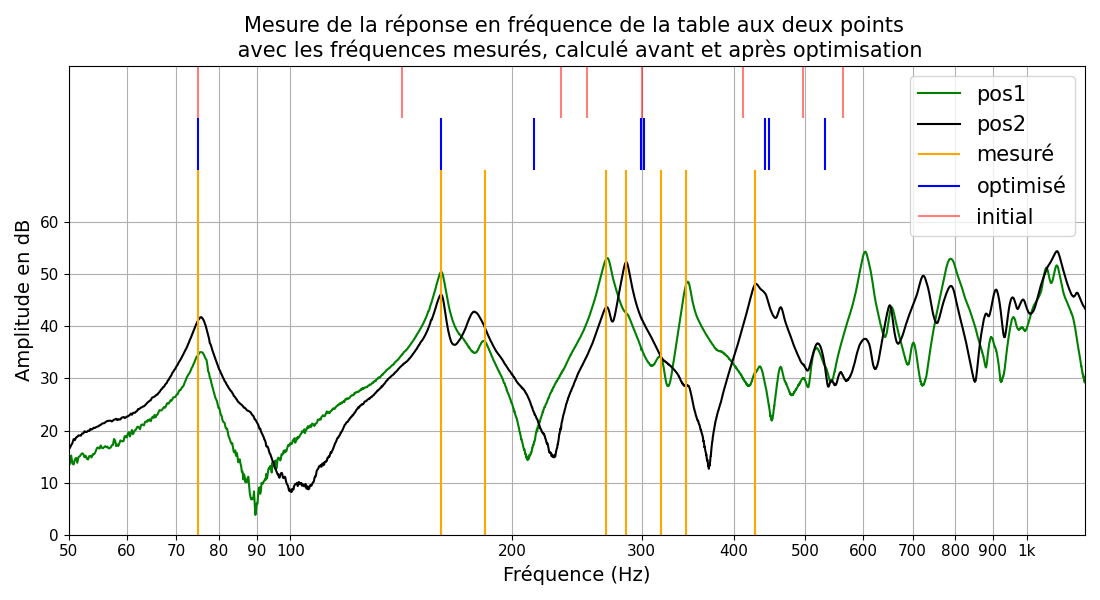

In [27]:
f_op = f_plaque(Lx_op, Ly_op,h_m1,E_nu_finale,rho_m1)
plt.figure(figsize = (11,6))
plt.semilogx(freq1,20*np.log10(np.abs(FRF1)),'g',label='pos1')
plt.semilogx(freq2,20*np.log10(np.abs(FRF2)),'k',label='pos2')
plt.vlines(f_fond[0],ymin=0,ymax=70,ls='-',color='orange',label = 'mesuré')
plt.vlines(f_op[0],ymin=70,ymax=80,ls='-',color='blue',label="optimisé")
plt.vlines(f_base[0],ymin=80,ymax=90,ls='-',color='r',label="initial",alpha=0.5)
plt.ylim(0,90)
for i in range(1,8):
    plt.vlines(f_fond[i],ymin=0,ymax=70,ls='-',color='orange')
    plt.vlines(f_op[i],ymin=70,ymax=80,ls='-',color='blue')
    plt.vlines(f_base[i],ymin=80,ymax=90,ls='-',color='red',alpha=0.5)

plt.grid()
plt.legend(fontsize=15)
plt.yticks([0,10,20,30,40,50,60],[0,10,20,30,40,50,60],size=11)
plt.xticks([50,60,70,80,90,100,200,300,400,500,600,700,800,900,1000],['50','60','70','80','90','100','200','300','400','500','600','700','800','900','1k'],size=11)
plt.xlabel("Fréquence (Hz)",size=14)
plt.ylabel("Amplitude en dB",size=14)
plt.xlim(50,1200)
plt.title("Mesure de la réponse en fréquence de la table aux deux points \n avec les fréquences mesurés, calculé avant et après optimisation", size = 15)
plt.tight_layout()
plt.savefig("freq_mes_et_opt",dpi=300, transparent = True)
plt.show()

Valeur gardé : 

Lx = 0.31636363636363635

Ly = 0.2466060606060606

E_nu_finale = 3457372289.45938

xinB = [0.088747,0.053920,0.112417,0.052442,0.053975,0.013130,0.013130,0.061390,0.037500]

In [25]:
def frf_from_AS_plate(x_idx, y_idx, xin, wn, w, phi_Nx_Ny_Nm) :
    FRF_model = - w**2 * np.sum(phi_Nx_Ny_Nm[np.newaxis,x_idx,y_idx,:]**2/(wn[np.newaxis,:]**2 + 2j*xin[np.newaxis,:]*wn[np.newaxis,:]*w[:,np.newaxis] - w[:,np.newaxis]**2), axis=1)
    return FRF_model

xinB = np.array([0.088747/2,0.053920/4,0.112417,0.052442,0.053975,0.013130,0.013130,0.061390,0.037500])/5
import mymodule2 as m
x1_idx = m.find_nearest_index(x,X_che1*1e-2)
y1_idx = m.find_nearest_index(y,Y_che1*1e-2)
x2_idx = m.find_nearest_index(x,X_che2*1e-2)
y2_idx = m.find_nearest_index(y,Y_che2*1e-2)

phiB_Nx_Ny_NmB = phiB_NxNy_NmB.reshape((Nx,Ny,-1))
wn = f_op*2*np.pi
w = 2*np.pi*freq1[1:]

FRF_model1 = - w**2 * np.sum(phiB_Nx_Ny_NmB[np.newaxis,x1_idx,y1_idx,:]**2/(wn[np.newaxis,:]**2 + 2j*xinB[np.newaxis,:]*wn[np.newaxis,:]*w[:,np.newaxis] - w[:,np.newaxis]**2), axis=1)
FRF_model2 = - w**2 * np.sum(phiB_Nx_Ny_NmB[np.newaxis,x2_idx,y2_idx,:]**2/(wn[np.newaxis,:]**2 + 2j*xinB[np.newaxis,:]*wn[np.newaxis,:]*w[:,np.newaxis] - w[:,np.newaxis]**2), axis=1)

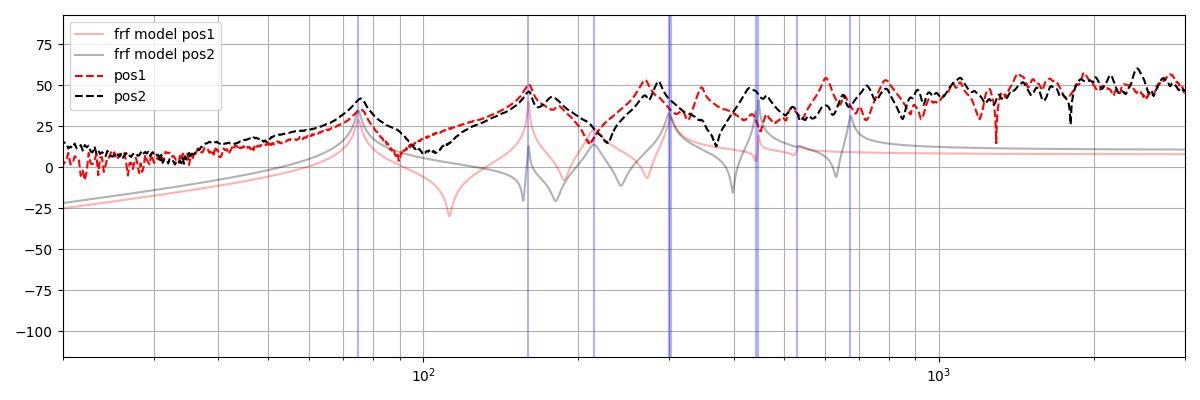

In [26]:
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(111)

ax1.semilogx(freq1[1:],20*np.log10(np.abs(FRF_model1)),label="frf model pos1", color="r", alpha=0.3)
ax1.semilogx(freq1[1:],20*np.log10(np.abs(FRF_model2)),label="frf model pos2", color="k", alpha=0.3)
ax1.semilogx(freq1,20*np.log10(np.abs(FRF1)),label="pos1", color="r", ls="--")
ax1.semilogx(freq2,20*np.log10(np.abs(FRF2)),label="pos2", color="k", ls="--")
ax1.grid(which="both")
ax1.legend()
ax1.set_xlabel("")
ax1.set_ylabel("")
ax1.set_title(r"")
ax1.set_xlim(20,3000)
ylims = ax1.set_ylim()
ax1.vlines(f_op, *ylims, color="b", alpha=0.3)

fig.tight_layout()

plt.show()